### Angular clustering in a series of bins, without cross correlations and free photo-z parameters

Here we extend the code to multiple ($N_{bins}$) redshift bins.

We do not take into account cross-correlations.

In our forecast we leave as free parameters:

$\bullet$ The cosmological parameters $\Omega_m, \sigma_8$.

$\bullet$ One photometric redshift scatter parameter $\sigma_{z,0}$.

$\bullet$ $N_{bins}$ photometric redshift bias parameters $z_b^i$. 

$\bullet$ $N_{bins}$ galaxy bias factors $b_g^i$.

So, in total, $2N_{bins}$ + 3 parameters.

Here is the "algorithm" for this code:

$-$ First write functions that calculate the angular spectra and their derivatives with respect to the cosmological and nuisance parameters.

$-$ Then, calculate the Fisher matrix for a single bin. In previous versions, with nuisance parameters fixed, there was no need to specify the order of the bin. Here in every bin, we have a big $(2N_{bins} + 3) \times (2N_{bins} + 3)$ Fisher matrix, with many zero entries (entries  for the cosmological parameters, the photo-z spread and for galaxy bias / redshift bias only at the places for the specific bins).

$-$ Sum the Fisher matrices to get the total Fisher matrix.


In [1]:
#import stuff
import numpy as np 
import scipy
from scipy.special import erf
from scipy import interpolate 
from scipy.interpolate import UnivariateSpline
import camb
from camb import model, initialpower
from scipy.special import gamma

In [2]:
# Now create a class that can create CAMB cosmologies for different matter densities and sigma_8
class Cosmology:
    
    def __init__(self,omega_m,sigma_8,h,z):
        self.omega_m = omega_m
        self.sigma_8 = sigma_8
        self.h = h
        self.z = z
        self.k_max = 10.0
        self.c = 2.99792e+5
        
        
        #=========================
        
        
        cosmo = camb.CAMBparams()
        cosmo.set_cosmology(H0=100.0*self.h, ombh2=0.048*(self.h**2.0), omch2=(self.omega_m - 0.048)*(self.h**2.0), mnu=0.06, omk=0, tau=0.06)
        cosmo.InitPower.set_params(As=2.0e-9, ns=0.973)
        results = camb.get_results(cosmo)
        cosmo.set_matter_power(redshifts=[0.0], kmax=10.0)
        cambres= camb.get_transfer_functions(cosmo)
        cosmo.NonLinear = model.NonLinear_both
        kh, z, pk = cambres.get_matter_power_spectrum(minkh=1e-3, maxkh=1.0, npoints = 10)
        sigma_8_temp = cambres.get_sigma8()
        As_new  = ((self.sigma_8/sigma_8_temp)**2.0)*(2.0e-9)
        cosmo.InitPower.set_params(As=As_new, ns=0.973)
        cambres = camb.get_results(cosmo)
        backres = camb.get_background(cosmo)

        self.chi = backres.comoving_radial_distance(self.z)
           
        self.PK = camb.get_matter_power_interpolator(cosmo, nonlinear=True, 
                hubble_units=False, k_hunit=False, kmax=self.k_max, zmin = 0.0, zmax=self.z[-1]) 
        
        self.H_z = (backres.hubble_parameter(self.z))/self.c #Hubble parameter in 1/Mpc 
        
        
#===================================================================================================================
#===================================================================================================================

# Selecting cosmologies

# Instantize cosmologies 

omega_m = 0.301
sigma_8 = 0.798
h = 0.682
alpha_om  = omega_m/10.0
alpha_sig = sigma_8/10.0

#==========================
nz = 1000 #number of steps to use for the radial/redshift integration

zarray = np.linspace(0,4.0,nz)
z = zarray[1:-1]

cosmo_fid = Cosmology(omega_m, sigma_8, h, z)
cosmo_1 = Cosmology(omega_m + alpha_om, sigma_8, h, z)
cosmo_2 = Cosmology(omega_m - alpha_om, sigma_8, h, z)
cosmo_3 = Cosmology(omega_m, sigma_8 + alpha_sig, h, z)
cosmo_4 = Cosmology(omega_m, sigma_8 - alpha_sig, h, z)

#=====================================================================================================
#=====================================================================================================

def cosmoselector(omega, sigma):
    #function that selects cosmology
    
    omfid = 0.301
    sigfid = 0.798
    
    cosmo_dict = {'cosmo_fid': cosmo_fid,
                  'cosmo_1' : cosmo_1,
                  'cosmo_2' : cosmo_2,
                  'cosmo_3' : cosmo_3,
                  'cosmo_4' : cosmo_4}
    
    
    if (omega==omfid):
        if (sigma == sigfid):
            cosm_sel = cosmo_dict['cosmo_fid']
        elif (sigma > sigfid):
            cosm_sel = cosmo_dict['cosmo_3']
        else:
            cosm_sel = cosmo_dict['cosmo_4']
    elif (omega > omfid): 
        cosm_sel = cosmo_dict['cosmo_1']
    else:
        cosm_sel = cosmo_dict['cosmo_2']
        
    
    return cosm_sel

In [3]:
# Calculation of Window fuction and C_l in a bin
#===================================================================================
#Function that calculates and returns window function W(z) for clustering in a bin i


def W_z_clust(z, dz, z_i, z_f, sig_z, z_bias, bias, z_0, a, b):
    """
    Function that calculates the window function for 2D galaxy clustering
    -----------------
    Inputs:
    z: array of redshifts used to calculate the window function
    dz: array of dz's - useful for the integral
    z_i : lower redshift limit of the bin
    z_f : upper redshift limit of the bin
    sig_z : photometric error spread
    z_bias : redshift bias
    bias : galaxy bias
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    The window function and its integral over all redshifts for a given bin with given limits
    
    """
    
    # Overall redshift distribution
    pref = b/(z_0*gamma((a+1.0)/b))
    dNdz = pref*((z/z_0)**a)*np.exp(-(z/z_0)**b)
    
    
    # Photometric window function
    x_min = (z - z_i - z_bias)/((1.0+z)*sig_z*np.sqrt(2.0))
    x_max = (z - z_f - z_bias)/((1.0+z)*sig_z*np.sqrt(2.0))
    F_z = 0.5*(erf(x_min) - erf(x_max))
    
    # Normalization
    norm_const = np.dot(dz, dNdz*F_z)
    
    # Window function 
    
    W_z_bin = bias*dNdz*F_z/norm_const

    return W_z_bin, norm_const   



#==================================================================================================
#==================================================================================================
# Function that calculates C_l,i

def C_l_i(z_i,z_f, sig_z, z_bias, bias, Omega_m_var , sig_8_var, z_0, a, b):
    """
    Function that calculates the C_l in a bin
    -----------------
    Inputs:
    z_i : lower redshift limit of the bin
    z_f : upper redshift limit of the bin
    sig_z : photometric error
    z_bias : redshift bias
    bias: constant bias factor in a bin
    Omega_m_var: Omega matter - can change
    sig_8_var : Sigma_8 parameter - can change
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    --------------
    Returns:
    ls and C_l  in a bin i
    """
    
    # Constant
    h = 0.682
    c = 2.99792e+5
    
    #======================================
    #====================================================================================
    #====================================================================================
    # Selecting cosmology
    
    cosmo = cosmoselector(Omega_m_var, sig_8_var)
    
    #====================================================================================
    #====================================================================================
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    #Calculate square of the window function
    W_sq = (W_z_clust(zarray, dzarray, z_i, z_f, sig_z, z_bias, bias, z_0, a, b)[0])**2.0
    #===================================================================================
    #===================================================================================
    #Calculate Hubble parameter and comoving distance
    Hubble = cosmo.H_z
    # Get comoving distance - in Mpc/h
    chis = cosmo.chi
    #========================================================
    # Get the full prefactor of the integral
    prefact = W_sq*Hubble/(chis**2.0)
    #===================================================================================
    #===================================================================================
    #Do integral over z
    
    ls_lin = np.linspace(1.0, np.log10(2000.0), 55, dtype = np.float64)
    
    ls = 10.0**ls_lin
    
    c_ell=np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        c_ell[i] = np.dot(dzarray, w*cosmo.PK.P(zarray, k, grid=False)*prefact)
    
    
    #===================================================================================
    # Retrurn the array of C_ell
    
    return ls, c_ell

In [4]:
# Derivatives with respect to the cosmological parameters - matter density and sigma_8

# Derivative with respect to matter density
def matter_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l with respect to matter density
    -----------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin
    sig_z : photometric error
    z_bias : redshift bias
    bias: constant bias factor in a bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    ---------------
    Returns:
    derivative w/r to matter of C_l in a bin i
    """
    alpha_m = Omega_m/10.0
    
    C_mat_1 = C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m+alpha_m , sig_8, z_0, a, b)[1]
    C_mat_2 = C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m-alpha_m , sig_8, z_0, a, b)[1]
    
    mat_der = (C_mat_1 - C_mat_2)/(2.0*alpha_m)
    return mat_der
    
    
#===============================================================================================
#===============================================================================================
# Derivative with respect to sigma_8   
def sigma_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l with respect to sigma_8 
    -----------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin
    sig_z : photometric error
    bias: constant bias factor in a bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    derivative w/r to sigma_8 in a bin i
    """
    
    alpha_s = sig_8/10.0
    
    C_sig_1 = C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m, sig_8+alpha_s, z_0, a, b)[1]
    C_sig_2 = C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sig_8-alpha_s, z_0, a, b)[1]
    
    sig_der = (C_sig_1 - C_sig_2)/(2.0*alpha_s)
    return sig_der

#==========================================================================================================
#==========================================================================================================
# Derivative with respect to galaxy bias in a bin

def bias_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l with respect to galaxy bias
    -----------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin
    sig_z : photometric error scatter
    z_bias : photometric error bias
    bias: constant bias factor in a bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    derivative w/r to galaxy bias in a bin i
    """
    
    alpha_b = bias/10.0
    
    C_bias_1 = C_l_i(z_i, z_f, sig_z, z_bias, bias+alpha_b, Omega_m, sig_8, z_0, a, b)[1]
    C_bias_2 = C_l_i(z_i, z_f, sig_z, z_bias, bias-alpha_b, Omega_m, sig_8, z_0, a, b)[1]
    
    bias_der = (C_bias_1 - C_bias_2)/(2.0*alpha_b)
    
    return bias_der

In [5]:
# Derivatives with respect to the two photo-z parameters - sigma_{z,0} and z_{bias}

def z_bias_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l with respect to photo_z bias
    -----------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin
    sig_z : photometric error scatter
    z_bias : photometric error bias
    bias: constant bias factor in a bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    derivative w/r to photo_z bias in a bin i
    """
    
    alpha_z_b = 0.01
    
    C_z_bias_1 = C_l_i(z_i, z_f, sig_z, z_bias+alpha_z_b, bias, Omega_m, sig_8, z_0, a, b)[1]
    C_z_bias_2 = C_l_i(z_i, z_f, sig_z, z_bias-alpha_z_b, bias, Omega_m , sig_8, z_0, a, b)[1]
    
    z_bias_der = (C_z_bias_1 - C_z_bias_2)/(2.0*alpha_z_b)
    return z_bias_der

#===========================================================================================================
#===========================================================================================================

def sig_z_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sig_8, z_0, a, b):
    """
    Function that calculates the derivative of C_l with respect to photo_z scatter
    -----------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin
    sig_z : photometric error scatter
    z_bias : photometric error bias
    bias: constant bias factor in a bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------
    Returns:
    derivative w/r to photo_z scatter in a bin i
    """
    
    alpha_sig = 0.01
    
    C_sig_z_1 = C_l_i(z_i, z_f, sig_z + alpha_sig, z_bias, bias, Omega_m, sig_8, z_0, a, b)[1]
    C_sig_z_2 = C_l_i(z_i, z_f, sig_z - alpha_sig, z_bias, bias, Omega_m , sig_8, z_0, a, b)[1]
    
    sig_z_der = (C_sig_z_1 - C_sig_z_2)/(2.0*alpha_sig)
    return sig_z_der

In [6]:
# Function that calculates the Fisher matrix for a single bin 

def Fish_single_bin(z_i, z_f, N_bins, i_bin, sig_z, z_bias, bias, f_sky, N_gal, z_0, a, b):
    """
    
    Calculates and returns the Fisher matrix for a single bin
    ------------------------------------------------
    Inputs:
    z_i : Lower limit of the redshift bin
    z_f : Upper limit of the redshift bin 
    N_bins : total number of bins
    i_bin : the order (number of bin we use in this case) - starts from One (1 <= i_bin <= N_bins)
    sig_z : photometric error spread 
    z_bias : redshift bias
    bias : constant galaxy bias factor in the bin
    f_sky : fraction of the sky the survey covers
    N_gal : number of galaxies in the bin
    z_0, a, b : parameters that define shape and mean z of the total redshift distribution
    ---------------------------------------
    Outputs:
    Fisher matrix for a single bin
    """
    
    #Some constants 
    
    Omega_m = 0.301
    sigma_8 = 0.798
    h = 0.682
    
    #Setting up cosmology - need to calculate chis
    
    # Setting up cosmology
    
    cosmo = camb.CAMBparams()
    cosmo.set_cosmology(H0=68.2, ombh2=0.048*(h**2.0), omch2=(Omega_m - 0.048)*(h**2.0), mnu=0.06, omk=0, tau=0.06)
    backres = camb.get_background(cosmo)
    #=============================================================
    
    #=============================================================
    
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    #==============================================================================
    # calculation of l_max
    
    z_mean = 0.5*(z_i+z_f)
    chi_mean = backres.comoving_radial_distance(z_mean)   # comoving distance corresponding to the mean redshift of the bin
    k_cutoff= 0.6*h #Cutoff scale in  Mpc^{-1}
    l_max = int(round(chi_mean*k_cutoff))
   
    
    #==============================================================================
    #==============================================================================
    #Calculation of the angular number density galaxies / steradian
    
    ster = f_sky*(4.0*np.pi)
    n_bin = N_gal/ster
    
    
    #===============================================================================
    # Now take the ls, C_ls and the derivatives of the C_ls - then keep only up to lmax
    ell_lin = np.linspace(1.0, np.log10(2000.0), 55, dtype = np.float64)
    
    
    C_ell_1 = C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m, sigma_8, z_0, a, b)[1] #C_ell's
    dC_ldOm_1 = matter_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m, sigma_8, z_0, a, b) #Matter derivative
    dC_ldsig8_1 = sigma_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m, sigma_8, z_0, a, b) #Sigma_8 derivative
    dC_ldbias_1 = bias_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m, sigma_8, z_0, a, b) # Galaxy bias derivative
    dC_ldz_bias_1  = z_bias_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sigma_8, z_0, a, b) # Photometric bias derivative
    dC_ldsig_z_1 = sig_z_der_C_l_i(z_i, z_f, sig_z, z_bias, bias, Omega_m , sigma_8, z_0, a, b) # Photometric scatter derivative

    
    #================================================================================
    
    #=================================================================================
    #=================================================================================
    #Find the breaking ells now 
    # First initialize 
    l_break_1 = ell_lin[-1]
    l_break_2 = ell_lin[-1]
    l_break_3 = ell_lin[-1]
    for s in range(0,np.size(dC_ldOm_1)):
        if (np.sign(dC_ldOm_1[s])>=0.0):
            l_break_1 = 0.5*(ell_lin[s] + ell_lin[s-1])
            break
            
    for s in range(0,np.size(dC_ldz_bias_1)):
        if (np.sign(dC_ldz_bias_1[s])>=0.0):
            l_break_2 = 0.5*(ell_lin[s]+ell_lin[s-1])
            break
    
    for s in range(0,np.size(dC_ldsig_z_1)):
        if (np.sign(dC_ldsig_z_1[s])>=0.0):
            l_break_3 = 0.5*(ell_lin[s]+ell_lin[s-1])
            break
            
    #==================================================================================        
    #==================================================================================
    ls = np.arange(10, 2000, dtype=np.float64)
    
    #Initialize
    
    C_ell = np.zeros(np.size(ls)) #C_ell's
    dC_ldOm = np.zeros(np.size(ls)) # matter derivative
    dC_ldsig8 = np.zeros(np.size(ls)) #sigma_8 derivative
    dC_ldbias = np.zeros(np.size(ls)) #galaxy bias derivative
    dC_ldz_bias = np.zeros(np.size(ls)) #z_bias derivtive
    dC_ldsig_z = np.zeros(np.size(ls)) #redshift error spread derivative
    
    #=================================================================================
    # Interpolate 
    
    C_l_matr_interp = UnivariateSpline(ell_lin, np.log10(C_ell_1+ 1.0e-20), s=0.0)
    C_om_mat_interp = UnivariateSpline(ell_lin, np.log10(abs(dC_ldOm_1+ 1.0e-20)), s=0.0)
    C_sig_interp = UnivariateSpline(ell_lin, np.log10(dC_ldsig8_1+1.0e-20), s=0.0)
    C_bias_interp = UnivariateSpline(ell_lin, np.log10(dC_ldbias_1+1.0e-20),s=0.0)
    C_zbias_interp = UnivariateSpline(ell_lin, np.log10(abs(dC_ldz_bias_1+1.0e-20)), s=0.0)
    C_sigz_interp = UnivariateSpline(ell_lin, np.log10(abs(dC_ldsig_z_1+1.0e-20)), s=0.0)
    
    #===============================================================================
    #populate
    
    for k, l in enumerate(ls):
        ell = np.log10(float(l))
        C_ell[k]  = 10.0**(C_l_matr_interp(ell))
        dC_ldsig8[k] = 10.0**(C_sig_interp(ell))
        dC_ldbias[k] = 10.0**(C_bias_interp(ell))
        
        if (ell < l_break_1):
            dC_ldOm[k] = -(10.0**C_om_mat_interp(ell))
        else: 
            dC_ldOm[k] = (10.0**C_om_mat_interp(ell))
            
        if (ell < l_break_2):
            dC_ldz_bias[k] = -(10.0**C_zbias_interp(ell))
        else: 
            dC_ldz_bias[k] = (10.0**C_zbias_interp(ell))
            
        if (ell < l_break_3):
            dC_ldsig_z[k] = -(10.0**C_sigz_interp(ell))
        else: 
            dC_ldsig_z[k] = (10.0**C_sigz_interp(ell))
            
            
    #=================================================================================
    ls = ls[:l_max-9]
    C_ell = C_ell[:l_max-9]
    dC_ldOm = dC_ldOm[:l_max-9]
    dC_ldsig8 = dC_ldsig8[:l_max-9]
    dC_ldbias = dC_ldbias[:l_max-9]
    dC_ldz_bias = dC_ldz_bias[:l_max-9]
    dC_ldsig_z = dC_ldsig_z[:l_max-9]
    
    #Create arrays with sigma^2
    sigma_sq = (2.0/(f_sky*(2.0*ls + 1.0)))*((C_ell + 1.0/n_bin)**2.0)
    #and its inverse - it will be useful 
    inv_sigma = 1.0/sigma_sq # inverse of sigma square - that's what we want
    
    #===============================================================================
        
    #===============================================================================
    #===============================================================================
    # Calculation of the elements of the Fisher matrix
    
    dim = 2*N_bins + 3
    #The Fisher matrix at each bin has dimensions (2*N_bins +3)*(2*N_bins +3)
    Fish = np.zeros([dim,dim])
    #Labels correspond to:
    # 0 = matter, 1 = sigma_8, 2 = photo_z scatter (common for all bins)
    # 2 + i_bin = photo_z bias in the i-th bin, 2 + N_bins + i_bin = galaxy bias in the i-th bin
    
    
    # Diagonal terms first
    Fish[0,0] = sum(inv_sigma*(dC_ldOm**2.0))
    Fish[1,1] = sum(inv_sigma*(dC_ldsig8**2.0))
    Fish[2,2] = sum(inv_sigma*(dC_ldsig_z**2.0))
    Fish[2+i_bin,2+i_bin] = sum(inv_sigma*(dC_ldz_bias**2.0))
    Fish[2 + N_bins + i_bin,2 + N_bins + i_bin] = sum(inv_sigma*(dC_ldbias**2.0))
    
    
    #Non-diagonal terms now 
    Fish[0,1] = Fish[1,0] = sum(inv_sigma*dC_ldOm*dC_ldsig8)
    Fish[0,2] = Fish[2,0] = sum(inv_sigma*dC_ldOm*dC_ldsig_z) 
    Fish[0,2 + i_bin] = Fish[2 + i_bin, 0] = sum(inv_sigma*dC_ldOm*dC_ldz_bias)
    Fish[0,2 + N_bins + i_bin] = Fish[2 + N_bins + i_bin,0] = sum(inv_sigma*dC_ldOm*dC_ldbias)
    
    
    Fish[1,2] = Fish[2,1] = sum(inv_sigma*dC_ldsig8*dC_ldsig_z)
    Fish[1,2 + i_bin] = Fish[2 + i_bin,1] = sum(inv_sigma*dC_ldsig8*dC_ldz_bias)
    Fish[1,2 + N_bins + i_bin] = Fish[2 + N_bins + i_bin,1] = sum(inv_sigma*dC_ldsig8*dC_ldbias)
    
    
    Fish[2,2 + i_bin] = Fish[2 + i_bin,2] = sum(inv_sigma*dC_ldsig_z*dC_ldz_bias)
    Fish[2,2 + N_bins + i_bin] = Fish[2 + N_bins + i_bin,2] = sum(inv_sigma*dC_ldsig_z*dC_ldbias)
    
    
    Fish[2 + i_bin,2 + N_bins + i_bin] = Fish[2 + N_bins + i_bin,2 + i_bin] = sum(inv_sigma*dC_ldz_bias*dC_ldbias)    
    
    
    return Fish
    
    
    

In [7]:
def Full_Fisher(z_init, z_final, N_bins, sig_z, f_sky, N_gal_tot, z_0, a, b):

    """
    Calculates and returns the total Fisher matrix for N bins

    z_init : initial redshift
    z_final : final redshift
    N_bins : number of bins
    sig_z : redshift error
    f_sky : fraction of the sky the survey covers 
    N_gal_tot : total number of galaxies
    z_0, a, b: : parameters that define shape and mean z of the total redshift distribution
    ---------------------------------------
    Outputs:
    Total Fisher matrix
    """
    #==========================================================================
    # Fiducial value for the redshift bias - this is constant in every redshift bin
    
    z_bias = 0.0 
    
    #==========================================================================
    #Redshift range for calculations and integration
    zarray = np.linspace(0,4.0,1000)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    #========================================================================
    # First of all find the limits of the bin 


    delta_z = (z_final - z_init)/N_bins # Width of each bin

    z_lims = np.zeros(N_bins+1) #An empty array that will contain the upper and lower limits of the bins
                                #The number of limits is equals the number of bins plus one
    
    # Now populate the array of the redshift limits
    for i in range (0,N_bins+1):
        z_lims[i] = z_init + i*delta_z

    #=========================================================================

    # Find normalizations 
    # This array containts the normalizations - or the integrals of the bins

    norm_of_bins = np.zeros(N_bins)

    # Populate them

    for i in range(0,N_bins):
        z_i_bin = z_lims[i]
        z_f_bin = z_lims[i+1]
        
        bias = 1.0 + 0.5*(z_i_bin + z_f_bin) #galaxy bias model adopted here is 1 + z_m

        norm_of_bins[i] = W_z_clust(zarray, dzarray, z_i_bin, z_f_bin, sig_z, z_bias, bias, z_0, a, b)[1]
        
    # Overall normalization

    tot_norm = np.sum(norm_of_bins)
    N_gal_in_bins = (N_gal_tot/tot_norm)*norm_of_bins
    

    # Now we have Everything we want to calculate the full Fisher matrix
    #=================================================================================
    # Initialize fisher matrix

    dim = 2*N_bins + 3
    #The total Fisher matrix has dimensions (2*N_bins +3 )*(2*N_bins + 3)
    
    Full_Fish = np.zeros([dim,dim])

    for i in range(N_bins):
        z_i_bin = z_lims[i]
        z_f_bin = z_lims[i+1]

        N_gal_bin = N_gal_in_bins[i]
        #N_gal_bin = N_gal_tot/N_bins
        
        
        bias = 1.0 + 0.5*(z_i_bin + z_f_bin) #galaxy bias model adopted here is 1 + z_mean
        
        i_bin = i + 1     #the bin number - starting from one
        
        
        Full_Fish += Fish_single_bin(z_i_bin, z_f_bin, N_bins, i_bin, sig_z, z_bias, bias, f_sky, N_gal_bin, z_0, a, b)


    return Full_Fish


In [8]:
z_init = 0.4
z_final = 0.6
sig_z = 0.1
f_sky = 4580.0/41253.0
N_gal_tot = 2.8e7
N_bins = 1
z_0 = 0.5
a = 2.0
b = 2.0

Fisher = Full_Fisher(z_init, z_final, N_bins, sig_z, f_sky, N_gal_tot, z_0, a, b)

In [9]:
# Import CosmicFish now
import math
import sys
import os
import IPython
#=================================================================================
cosmicfish_pylib_path = '/Users/Dimitris/Desktop/Candidacy_all/Theory/CosmicFish/python'
sys.path.insert(0, os.path.normpath(cosmicfish_pylib_path))
#================================================================================
import cosmicfish_pylib.utilities            as fu
import cosmicfish_pylib.colors               as fc
import cosmicfish_pylib.fisher_matrix        as fm
import cosmicfish_pylib.fisher_derived       as fd
import cosmicfish_pylib.fisher_operations    as fo
import cosmicfish_pylib.fisher_plot_settings as fps
import cosmicfish_pylib.fisher_plot_analysis as fpa
import cosmicfish_pylib.fisher_plot          as fp

In [10]:
import matplotlib.pyplot as plt
matrix = Fisher
from code.plot_utils import plot_pretty

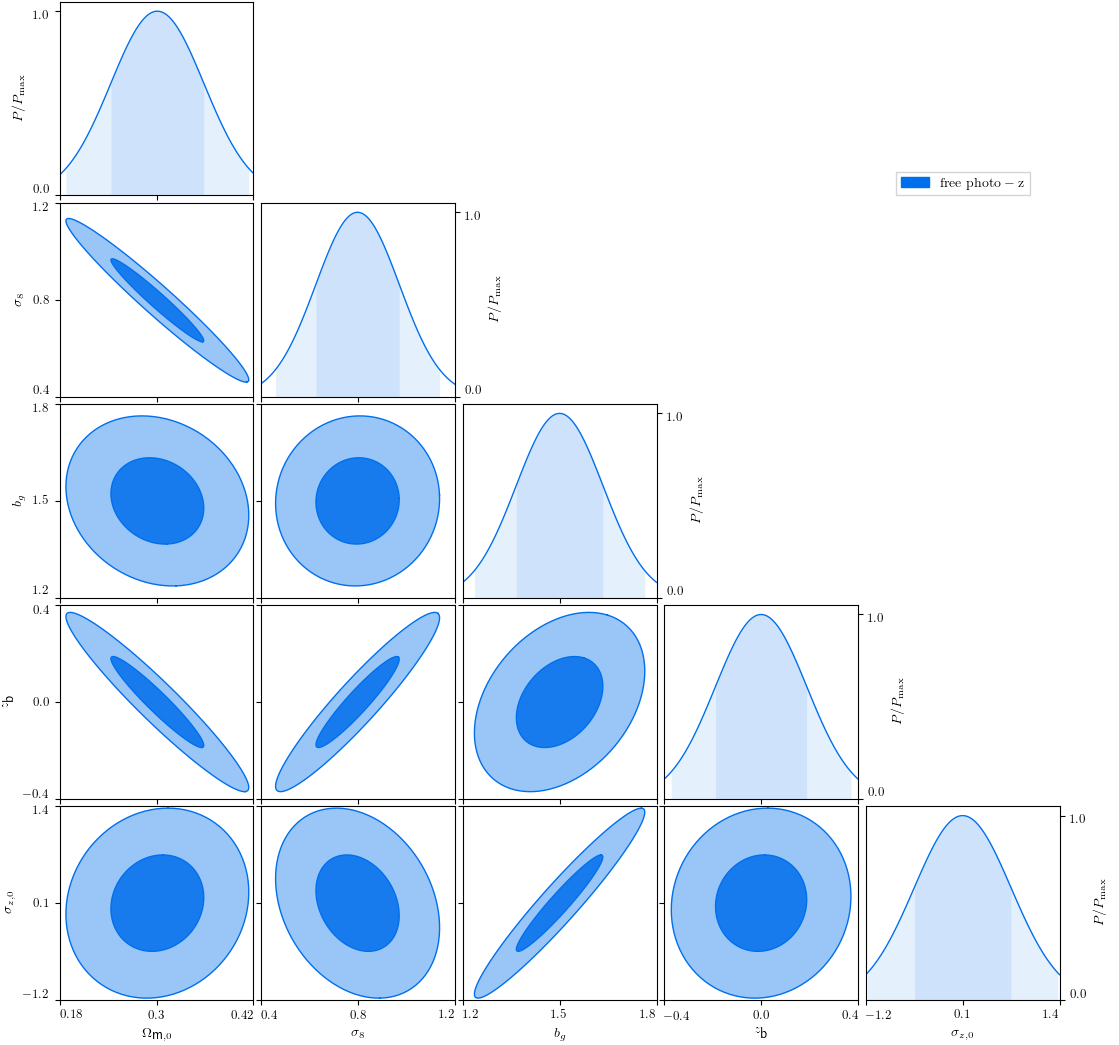

In [11]:
param_names = ['$\Omega_{\mbox{m},0}$', '$\sigma_8$', '$b_g$','$z_{\mbox{b}}$', '$\sigma_{z,0}$']

fiducial = [0.301, 0.798, 1.5, 0.0, 0.1]

fisher = fm.fisher_matrix(fisher_matrix=matrix, fiducial = fiducial, param_names=param_names )
fisher.name = 'free photo-z'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('free_phot.pdf', dpi=100)
fisher_plotter.export('free_phot.png', dpi=100)
IPython.display.Image(filename='free_phot.png',unconfined=True)